# Khám Phá Dữ Liệu Lightcurve

Notebook này thực hiện khám phá ban đầu về dữ liệu lightcurve (đường cong ánh sáng) của các thiên thể trong bộ dữ liệu MALLORN.

## Mục tiêu:
- Đọc và hiểu cấu trúc dữ liệu lightcurve
- Trực quan hóa lightcurve của một đối tượng TDE cụ thể
- Quan sát đặc điểm bùng sáng của TDE qua các filter khác nhau

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
from pathlib import Path

# Đường dẫn tới thư mục dataset
BASE_DIR = Path(r"E:\code\ML\MALLORN-Astronomical-Classification-Challenge\mallorn-astronomical-classification-challenge")
OUTPUT_DIR = Path(r"E:\code\ML\MALLORN-Astronomical-Classification-Challenge\ver0")

# 1) Đọc train_log
train_log_path = BASE_DIR / "train_log.csv"
train_log = pd.read_csv(train_log_path)

# 2) Chọn 1 object cụ thể
# Cách 1: chọn 1 TDE ngẫu nhiên
tde_row = train_log[train_log["target"] == 1].iloc[0]

# Nếu muốn chọn tay 1 object (ví dụ amon_imloth_luin), dùng:
# tde_row = train_log[train_log["object_id"] == "amon_imloth_luin"].iloc[0]

object_id = tde_row["object_id"]
split_name = tde_row["split"]

print("Object chọn:", object_id)
print("Split:", split_name)
print("SpecType:", tde_row["SpecType"], "  target:", tde_row["target"])

# 3) Đọc file lightcurve tương ứng với split
lc_path = BASE_DIR / split_name / "train_full_lightcurves.csv"
lc = pd.read_csv(lc_path)

# 4) Lọc lightcurve của đúng object_id này
lc_obj = lc[lc["object_id"] == object_id].copy()
lc_obj = lc_obj.sort_values("Time (MJD)")

print("Số điểm quan sát:", len(lc_obj))

# 5) Vẽ lightcurve: mỗi filter một màu
plt.figure(figsize=(10, 6))

for flt, group in lc_obj.groupby("Filter"):
    plt.errorbar(
        group["Time (MJD)"],
        group["Flux"],
        yerr=group["Flux_err"],
        fmt='o',
        markersize=3,
        alpha=0.8,
        label=flt
    )

plt.xlabel("Time (MJD)")
plt.ylabel("Flux (microJy)")
plt.title(f"Lightcurve of {object_id} ({tde_row['SpecType']}, target={tde_row['target']})")
plt.legend(title="Filter")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Hình: Lightcurve của một TDE (amon_imloth_luin)

Biểu đồ trên minh họa **đường cong ánh sáng (lightcurve)** của đối tượng `amon_imloth_luin`, được phân loại quang phổ là **TDE** (`SpecType = TDE`, `target = 1`):

- **Trục hoành (Time (MJD))**  
  Thời điểm quan sát, đơn vị MJD. Càng sang phải là quan sát càng về sau trong thời gian.

- **Trục tung (Flux (microJy))**  
  Độ sáng đo được của nguồn, đơn vị microjansky.  
  Giá trị quanh **0** tương ứng với mức nền; giá trị dương/lớn hơn cho thấy nguồn sáng hơn nền.

- **Các điểm màu và chú giải (legend Filter)**  
  Mỗi màu tương ứng với một **filter** khác nhau (`u, g, r, i, z, y`).  
  Tại cùng một thời điểm có thể có nhiều điểm khác màu vì nguồn được quan sát ở nhiều băng sóng khác nhau.

- **Thanh dọc (error bar)**  
  Thể hiện **sai số đo** (`Flux_err`) quanh mỗi giá trị `Flux`.  
  Thanh càng dài → phép đo càng kém chính xác, nhiều nhiễu.

Quan sát hình, ta thấy trước và sau giai đoạn bùng sáng, các điểm đo dao động nhỏ quanh 0 (nhiễu nền), trong khi ở khoảng giữa có một **đỉnh sáng rõ rệt** (flux tăng mạnh ở nhiều filter rồi giảm dần). Mẫu hình “yên lặng → bùng sáng → tắt dần” này là đặc trưng thường gặp của các sự kiện **TDE** trong bộ dữ liệu.

In [ ]:
import pandas as pd
from pathlib import Path
from IPython.display import display

BASE_DIR = Path(r"E:\code\ML\MALLORN-Astronomical-Classification-Challenge\mallorn-astronomical-classification-challenge")

train_log = pd.read_csv(BASE_DIR / "train_log.csv")
test_log  = pd.read_csv(BASE_DIR / "test_log.csv")

print("train_log shape:", train_log.shape)
print("test_log  shape:", test_log.shape)

print("\n== train_log head ==")
display(train_log.head())

print("\n== test_log head ==")
display(test_log.head())

### Quan sát về Redshift (Z) và sai số

**Phân biệt giữa Train và Test:**
- **Train**: Sử dụng spectroscopic redshift (Z từ phổ) → Z_err để trống (NaN), coi như sai số không đáng kể
- **Test**: Sử dụng photometric redshift (Z từ ảnh) → Z_err ≠ 0, phản ánh độ bất định khi ước lượng từ photometry

**Ý nghĩa cho mô hình:**
- Mô hình phải robust với việc Z ở tập test có nhiễu nhiều hơn train
- Trong baseline, chúng ta sử dụng Z như một feature đầu vào
- Z_err không được đưa vào mô hình (hoặc chỉ dùng để phân tích)

### Thiết kế dữ liệu có chủ đích

Đây là thiết kế dữ liệu có chủ đích để mô phỏng chênh lệch thực tế giữa:
- **Tập có phổ (spectroscopic)**: Train set - đo chính xác hơn
- **Tập photometric**: Test set - ước lượng từ ảnh, có sai số

Việc test có Z_err nhưng train không có yêu cầu mô hình phải đủ robust để xử lý redshift bị nhiễu khi triển khai thực tế.

In [3]:
print("== Z, EBV stats - train ==")
display(train_log[["Z", "EBV"]].describe())

print("\n== Z, EBV stats - test ==")
display(test_log[["Z", "EBV"]].describe())

== Z, EBV stats - train ==


,Z,EBV
count,3043.000000,3043.000000
mean,0.670674,0.055547
std,0.539269,0.061349
min,0.008771,0.002000
25%,0.317750,0.020000
50%,0.481800,0.037000
75%,0.883550,0.069000
max,4.924000,0.758000



== Z, EBV stats - test ==


,Z,EBV
count,7135.000000,7135.000000
mean,0.671834,0.055654
std,0.552350,0.068734
min,-0.017510,0.003000
25%,0.317050,0.019000
50%,0.484200,0.035000
75%,0.869900,0.067000
max,4.935000,1.236000


### Phân tích thống kê Redshift (Z)

**Quan sát chính:**
- Phân bố Z của train và test rất giống nhau (mean, median, quantile gần như trùng khớp)
- Test có giá trị min hơi âm (-0.018), do photo-z có thể ước lượng lệch một chút (về mặt vật lý Z < 0 không hợp lý, nhưng đây là artifact của ước lượng)
- Độ lệch chuẩn (std) của test cao hơn một chút → redshift test nhiễu hơn (phù hợp với việc test dùng photo-z)

**Kết luận cho Machine Learning:**
- Ít có covariate shift theo Z giữa train và test
- An toàn khi sử dụng Z làm feature đầu vào cho mô hình

### Phân tích hệ số suy giảm EBV (Extinction)

**Quan sát chính:**
- Mean, median, và quantile 25-75% rất giống nhau giữa train và test
- Test có đuôi phải dài hơn (max = 1.236 so với train max = 0.758) → một số object trong test bị bụi che khuất mạnh hơn train
- Nhưng nhìn chung phân bố EBV vẫn khá tương đồng

**Kết luận cho Machine Learning:**
- Có thể dùng EBV trực tiếp làm feature, hoặc dùng nó để de-extinct (loại bỏ ảnh hưởng bụi) cho flux
- Không có dấu hiệu covariate shift nghiêm trọng theo EBV

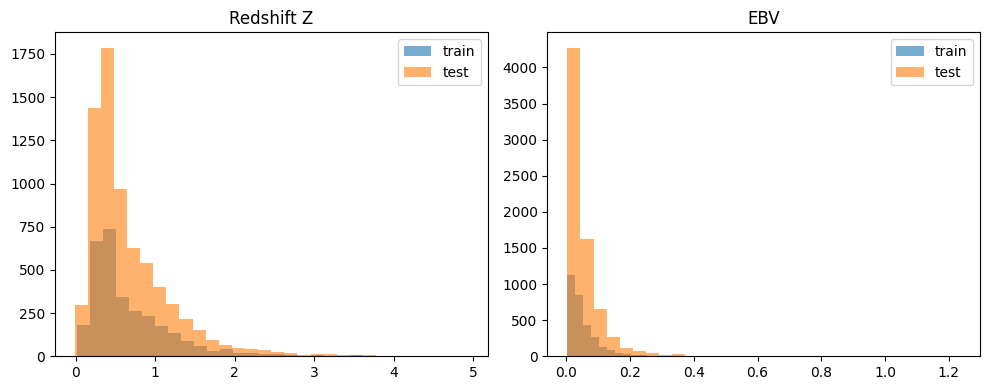

In [4]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].hist(train_log["Z"], bins=30, alpha=0.6, label="train")
axes[0].hist(test_log["Z"],  bins=30, alpha=0.6, label="test")
axes[0].set_title("Redshift Z")
axes[0].legend()

axes[1].hist(train_log["EBV"], bins=30, alpha=0.6, label="train")
axes[1].hist(test_log["EBV"],  bins=30, alpha=0.6, label="test")
axes[1].set_title("EBV")
axes[1].legend()

plt.tight_layout()
plt.show()

### Phân bố redshift Z và hệ số suy giảm EBV

Hình trên so sánh phân bố của **redshift Z** (trái) và **hệ số suy giảm EBV** (phải) giữa tập huấn luyện (màu xanh) và tập kiểm tra (màu cam):

- **Redshift Z**  
  Cả train và test đều tập trung mạnh ở giá trị thấp (Z < 1) và có đuôi kéo dài tới Z ≈ 4–5.  
  Hai histogram gần như chồng lên nhau về hình dạng và vị trí, cho thấy phân bố Z giữa hai tập dữ liệu là tương đồng.

- **EBV**  
  EBV chủ yếu rất nhỏ (≈ 0–0.1) và giảm nhanh khi tăng EBV, nghĩa là đa số nguồn chỉ bị suy giảm ánh sáng nhẹ do bụi.  
  Phân bố EBV của train và test cũng gần trùng nhau, chỉ khác nhẹ ở phần đuôi với một số đối tượng test có EBV lớn hơn.

Nhìn chung, **train và test có phân bố Z và EBV rất giống nhau**, nên không có covariate shift nghiêm trọng theo hai biến này và chúng có thể được sử dụng an toàn làm đặc trưng đầu vào cho mô hình.

In [5]:
splits = sorted(train_log["split"].unique())
summary = []

for split in splits:
    split_dir = BASE_DIR / split
    
    train_lc = pd.read_csv(split_dir / "train_full_lightcurves.csv")
    test_lc  = pd.read_csv(split_dir / "test_full_lightcurves.csv")
    
    summary.append({
        "split": split,
        "train_rows": len(train_lc),
        "train_objects": train_lc["object_id"].nunique(),
        "test_rows": len(test_lc),
        "test_objects": test_lc["object_id"].nunique(),
    })

summary_df = pd.DataFrame(summary)
display(summary_df)

print("\nTotal train objects from lightcurves:", summary_df["train_objects"].sum())
print("Total test  objects from lightcurves:", summary_df["test_objects"].sum())

,split,train_rows,train_objects,test_rows,test_objects
0,split_01,26324,155,59235,364
1,split_02,25609,170,71229,414
2,split_03,21676,138,53751,338
3,split_04,22898,145,51408,332
4,split_05,25934,165,61179,375
5,split_06,25684,155,57620,374
6,split_07,24473,165,65101,398
7,split_08,25571,162,61498,387
8,split_09,19690,128,47239,289
9,split_10,25151,144,51056,331



Total train objects from lightcurves: 3043
Total test  objects from lightcurves: 7135


### Kiểm tra tính nhất quán giữa train/test

**Cấu trúc mỗi split:**
- train_rows: ~20k-26k dòng quan sát
- train_objects: ~140-170 đối tượng
- test_rows: ~47k-71k dòng quan sát  
- test_objects: ~280-420 đối tượng

**Tổng cộng:**
- Total train objects: **3043** (khớp 100% với train_log.shape)
- Total test objects: **7135** (khớp 100% với test_log.shape)

**Kết luận:**
- ✓ Không bị thiếu hoặc trùng object giữa log và lightcurves
- ✓ Mỗi object_id trong log đều có lightcurve trong đúng một split

### Số điểm quan sát trung bình trên mỗi object

**Ví dụ split_01:**
- train_rows = 26,324, train_objects = 155
- → Trung bình ≈ **170 điểm quan sát / object**

**Các split khác:** Đều có số điểm quan sát tương tự (~100-200 điểm/object)

**Ý nghĩa:**
- Mỗi object có đủ nhiều phép đo flux (trong 6 filter) để trích xuất features và huấn luyện mô hình
- Dữ liệu time series không quá sparse (thưa thớt), khá dày đặc

In [6]:
# Đếm số điểm quan sát cho mỗi object trong train (gộp tất cả split)
obs_counts_list = []

for split in splits:
    train_lc = pd.read_csv(BASE_DIR / split / "train_full_lightcurves.csv")
    counts = train_lc["object_id"].value_counts()
    obs_counts_list.append(counts)

obs_counts = pd.concat(obs_counts_list)
obs_counts = obs_counts.groupby(obs_counts.index).sum()
obs_counts = obs_counts.rename("n_obs").to_frame()

print("== Số điểm quan sát / object (train) - overall stats ==")
display(obs_counts["n_obs"].describe())

# Gộp với target để xem TDE vs non-TDE khác gì không
obs_with_target = obs_counts.join(train_log.set_index("object_id")["target"])

print("\n== Số điểm quan sát theo target ==")
display(obs_with_target.groupby("target")["n_obs"].describe())

== Số điểm quan sát / object (train) - overall stats ==


count    3043.000000
mean      157.536641
std       108.795030
min        17.000000
25%       124.000000
50%       150.000000
75%       168.000000
max      1164.000000
Name: n_obs, dtype: float64


== Số điểm quan sát theo target ==


,count,mean,std,min,25%,50%,75%,max
target,,,,,,,,
0,2895.0,157.355440,109.602573,17.0,123.0,150.0,167.0,1164.0
1,148.0,161.081081,91.822997,28.0,140.0,153.5,171.0,1034.0
